In [11]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def backfill(df):
    # function to backfill blank or null values based on nearest available value
    for col in df:
        df[col] = (df[col].replace(0, np.nan)
                                          #.groupby(df['symbol'])
                                          .transform(lambda x: x.ffill().bfill())
                                          .fillna(0))
    return df

In [4]:
def get_quarter(value):
    current_month = float(value.split('-')[1])
    if current_month <= 3:
        return 'Q1'
    elif current_month <= 6:
        return 'Q2'
    elif current_month <= 9:
        return 'Q3'
    else: 
        return 'Q4'

In [5]:
def get_fmp_dataframe(url,attribute=None):
    response = requests.get(url)
    if attribute:
        return pd.DataFrame(response.json()[attribute])
    else:
        return pd.DataFrame(response.json())

In [25]:
def get_data(ticker):

    apikey = 'ed422f5ab8a52bef7a04a8d39de5129d'

    #Get historical stock price
    api_url5 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2019-02-01&to=2024-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_2 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2014-02-01&to=2019-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_3 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2009-02-01&to=2014-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_4 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2004-02-01&to=2009-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_5 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=1999-02-01&to=2004-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"

    df5_1 = get_fmp_dataframe(api_url5,"historical")
    df5_2 = get_fmp_dataframe(api_url5_2,"historical")
    df5_3 = get_fmp_dataframe(api_url5_3,"historical")
    df5_4 = get_fmp_dataframe(api_url5_4,"historical")
    df5_5 = get_fmp_dataframe(api_url5_5,"historical")

    df5 = pd.concat([df5_1,df5_2,df5_3,df5_4,df5_5])
    
    #add quarters
    df5['period'] = df5['date'].apply(lambda x: get_quarter(x))
    #add year
    df5['calendarYear'] = df5['date'].apply(lambda x: x.split('-')[0])
    historicalStockPrice = backfill(df5)


    # Get Income Statement Data
    api_url = f'https://financialmodelingprep.com/api/v3/income-statement/{ticker}?period=quarter&apikey={apikey}'
    response = requests.get(api_url)
    df = pd.DataFrame(response.json())
    # Join Income Statement
    incomeStatement = backfill(df.drop(columns=['date'],axis=1))
    merge1 = pd.merge(historicalStockPrice, incomeStatement[incomeStatement.columns.difference(historicalStockPrice.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])


    # Get Balance Sheet Data
    api_url2 = f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?period=quarter&apikey={apikey}'
    response2 = requests.get(api_url2)
    df2 = pd.DataFrame(response2.json())
    # Join Balance Sheet
    balanceSheet = backfill(df2.drop(columns=['date'],axis=1))
    merge2 = pd.merge(merge1, balanceSheet[balanceSheet.columns.difference(merge1.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])


    # Get Cashflow Statement
    api_url3 = f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{ticker}?period=quarter&apikey={apikey}'
    response3 = requests.get(api_url3)
    df3 = pd.DataFrame(response3.json())
    # Join Cash Flow Statement
    cashFlowStatement = backfill(df3.drop(columns=['date'],axis=1))
    merge3 = pd.merge(merge2, cashFlowStatement[cashFlowStatement.columns.difference(merge2.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])


    # Get Financial Statement Analysis
    api_url4 = f'https://financialmodelingprep.com/api/v3/key-metrics/{ticker}?period=quarter&apikey={apikey}'
    response4 = requests.get(api_url4)
    df4 = pd.DataFrame(response4.json())
    # Join Financial Analysis
    FSA = backfill(df4.drop(columns=['date'],axis=1))
    merge4 = pd.merge(merge3, FSA[FSA.columns.difference(merge3.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])
    
    merge4['date'] = pd.to_datetime(merge4['date'])
    
    return merge4



In [26]:
PLD = get_data('PLD')

In [27]:
PLD

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,...,returnOnTangibleAssets,revenuePerShare,roe,roic,salesGeneralAndAdministrativeToRevenue,shareholdersEquityPerShare,stockBasedCompensationToRevenue,tangibleAssetValue,tangibleBookValuePerShare,workingCapital
0,2024-01-16,130.27,131.525,129.1700,129.97,129.97,4000555,3999832,-0.30,-0.23029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-12,132.65,132.970,130.5950,131.55,131.55,2380625,2380600,-1.10,-0.82925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-11,132.68,132.990,130.5900,131.32,131.32,2787532,2787500,-1.36,-1.03000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-10,134.37,134.990,133.1000,133.55,133.55,2353964,2354000,-0.82,-0.61026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-09,131.71,134.330,130.6542,133.07,133.07,3109617,3109500,1.36,1.03000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6275,1999-02-05,21.94,21.940,21.7500,21.81,8.22,29500,29500,-0.13,-0.59253,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6276,1999-02-04,21.94,22.000,21.8800,21.94,8.27,100600,100600,-0.13,-0.59253,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6277,1999-02-03,22.06,22.060,21.9400,22.00,8.29,33400,33400,-0.06,-0.27199,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6278,1999-02-02,21.94,22.060,21.9400,22.06,8.32,80600,80600,0.12,0.54695,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0


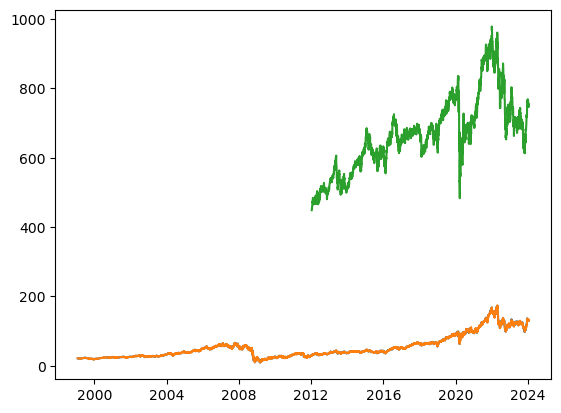

In [36]:
plt.plot(PLD['date'],PLD['close']);
plt.plot(PLD['date'],PLD['open']);
plt.plot(FNER_NAREIT_index['Date'],FNER_NAREIT_index['Open']);

In [21]:
plt.show()

In [32]:
FNER_NAREIT_index = pd.read_csv('^FNER.csv')

In [33]:
FNER_NAREIT_index['Date'] = pd.to_datetime(FNER_NAREIT_index['Date'])

In [34]:
FNER_NAREIT_index

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-13,448.820007,449.019989,444.589996,448.260010,448.260010,0.0
1,2012-01-16,449.880005,449.880005,449.880005,449.880005,449.880005,0.0
2,2012-01-17,449.880005,456.070007,449.880005,455.899994,455.899994,0.0
3,2012-01-18,453.089996,457.380005,453.040009,456.000000,456.000000,0.0
4,2012-01-19,456.589996,459.619995,456.160004,459.109985,459.109985,0.0
...,...,...,...,...,...,...,...
3027,2024-01-10,752.059998,756.380005,751.250000,755.260010,755.260010,0.0
3028,2024-01-11,753.679993,753.679993,743.510010,746.849976,746.849976,0.0
3029,2024-01-12,746.750000,756.150024,746.750000,752.989990,752.989990,0.0
3030,2024-01-15,746.750000,756.150024,746.750000,751.750000,751.750000,0.0


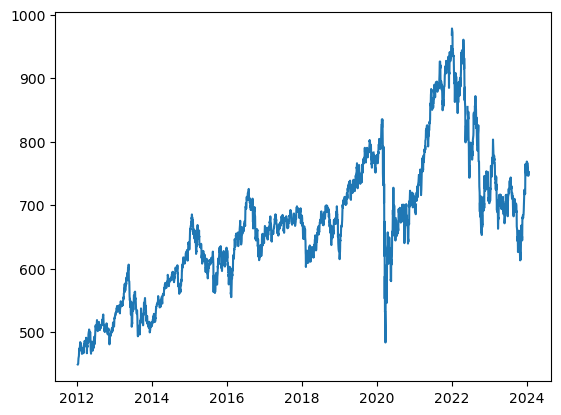

In [38]:
!pip3 install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/58/f7/a966b800b49cb5379e348bf0717df481051714a99ece15289718562f6952/yfinance-0.2.35-py2.py3-none-any.whl.metadata
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 747.2 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 2.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 1.6 MB/s eta 0:00:0000:01
  Created wheel for frozendict: filename=frozendict-2.4.0-py3-none-any.whl size=15425 sha256=b8c24cd6b182ae48f6403140a01f3bd888370252a661ae34b2

In [43]:
import yfinance as yf

In [48]:
FNER_raw = yf.Ticker("^FNER")

yfinance.ticker.Ticker

In [52]:
FNER =  pd.DataFrame(FNER_raw.history(period="Max"))
FNER.reset_index(inplace=True)

In [53]:
FNER

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-01-12 00:00:00+00:00,451.559998,451.869995,445.859985,446.269989,0,0.0,0.0
1,2012-01-13 00:00:00+00:00,448.820007,449.019989,444.589996,448.260010,0,0.0,0.0
2,2012-01-16 00:00:00+00:00,449.880005,449.880005,449.880005,449.880005,0,0.0,0.0
3,2012-01-17 00:00:00+00:00,449.880005,456.070007,449.880005,455.899994,0,0.0,0.0
4,2012-01-18 00:00:00+00:00,453.089996,457.380005,453.040009,456.000000,0,0.0,0.0
...,...,...,...,...,...,...,...,...
2997,2024-01-10 00:00:00+00:00,752.059998,756.380005,751.250000,755.260010,0,0.0,0.0
2998,2024-01-11 00:00:00+00:00,753.679993,753.679993,743.510010,746.849976,0,0.0,0.0
2999,2024-01-12 00:00:00+00:00,746.750000,756.150024,746.750000,752.989990,0,0.0,0.0
3000,2024-01-15 00:00:00+00:00,746.750000,756.150024,746.750000,751.750000,0,0.0,0.0


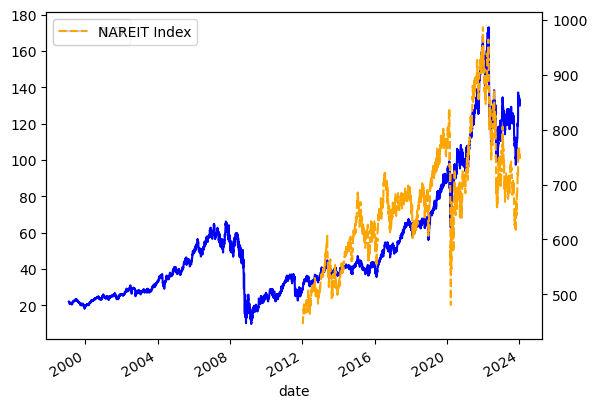

In [62]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
PLD.plot(x="date",y="close",ax=ax,color='blue',label='PLD');
FNER.plot(x="Date",y="Close",ax=ax2, ls="--", color="orange",label='NAREIT Index');

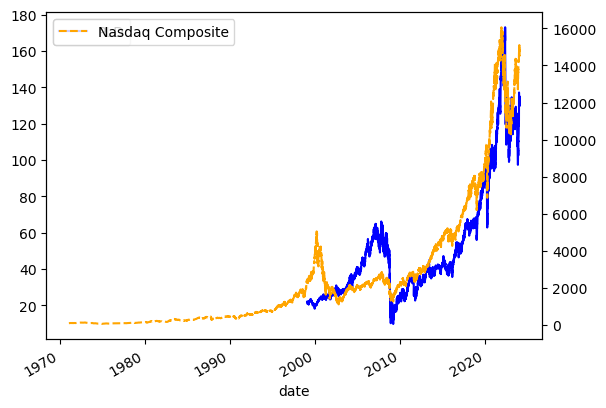

In [67]:
NASDAQ_Composite_raw = yf.Ticker("^IXIC")
IXIC =  pd.DataFrame(NASDAQ_Composite_raw.history(period="Max"))
IXIC.reset_index(inplace=True)


fig, ax = plt.subplots()
ax2 = ax.twinx()
PLD.plot(x="date",y="close",ax=ax,color='blue',label='PLD');
IXIC.plot(x="Date",y="Close",ax=ax2, ls="--", color="orange",label='Nasdaq Composite');